<a href="https://colab.research.google.com/github/Juliethandiwe/MIT-805-Assignment-Part-2/blob/main/Juliet_Rushambwe_MIT_805.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Chest X-rays(Indiana University)**



**Loading** **data**

Streaming output truncated to the last 5000 lines.
  inflating: images/images_normalized/2211_IM-0818-2001.dcm.png  
  inflating: images/images_normalized/2212_IM-0819-1001.dcm.png  
  inflating: images/images_normalized/2212_IM-0819-2001.dcm.png  
  inflating: images/images_normalized/2213_IM-0819-1001.dcm.png  
  inflating: images/images_normalized/2213_IM-0819-3001.dcm.png  
  inflating: images/images_normalized/2214_IM-0819-1002.dcm.png  
  inflating: images/images_normalized/2215_IM-0820-1001.dcm.png  
  inflating: images/images_normalized/2215_IM-0820-2001.dcm.png  
  inflating: images/images_normalized/2216_IM-0821-85075001.dcm.png  
  inflating: images/images_normalized/2216_IM-0821-85075002.dcm.png  
  inflating: images/images_normalized/2217_IM-0822-0001-0001.dcm.png  
  inflating: images/images_normalized/2217_IM-0822-0001-0002.dcm.png  
  inflating: images/images_normalized/2218_IM-0823-1001.dcm.png  
  inflating: images/images_normalized/2218_IM-0823-2001.dcm.png  
  infla

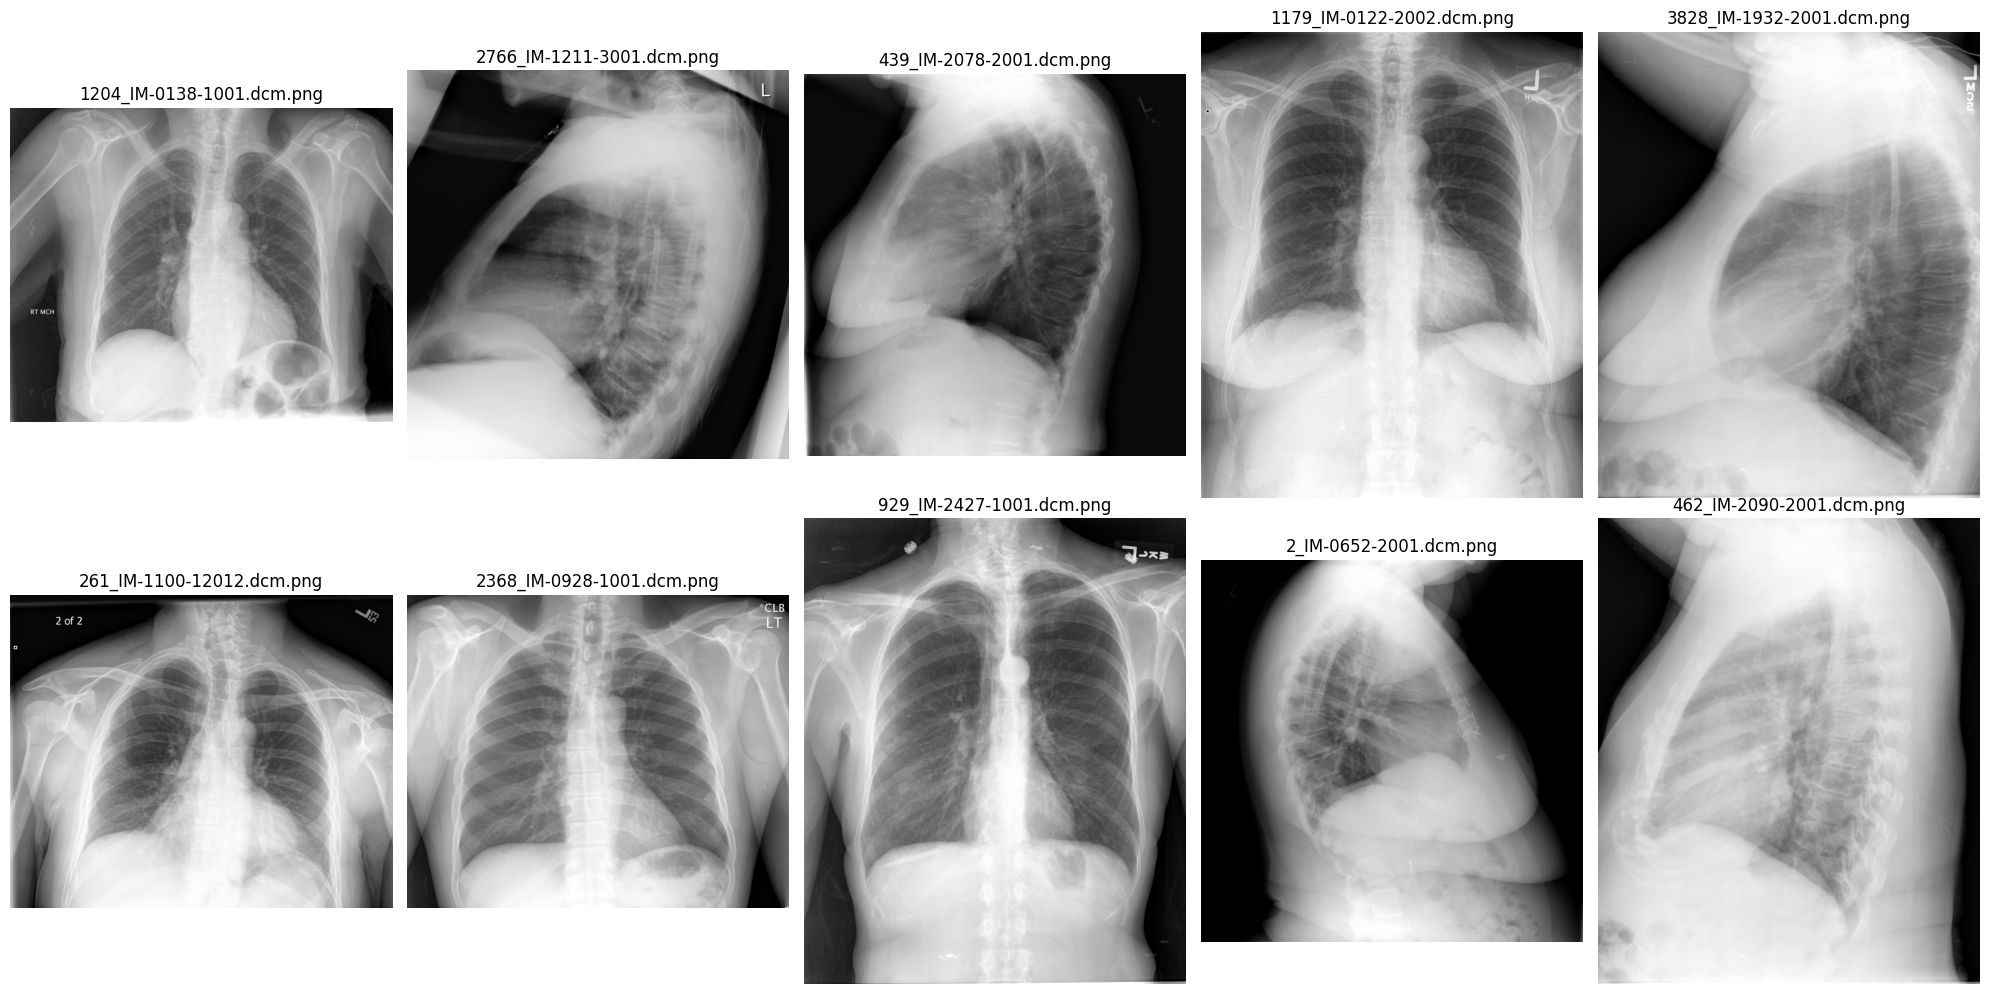

In [1]:
!pip install pyspark
from pyspark.sql import SparkSession
import os
import matplotlib.pyplot as plt
from PIL import Image

#SparkSession
spark = SparkSession.builder \
    .appName("Chest X-rays Analysis") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.memoryOverhead", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.default.parallelism", 200) \
    .getOrCreate()

#Download dataset
!kaggle datasets download -d raddar/chest-xrays-indiana-university
!unzip chest-xrays-indiana-university.zip

# Load the CSV datasets
reports_csv_path = "indiana_reports.csv"
projections_csv_path = "indiana_projections.csv"
reports_df = spark.read.csv(reports_csv_path, header=True, inferSchema=True)
projections_df = spark.read.csv(projections_csv_path, header=True, inferSchema=True)
# Show the first few rows of each DataFrame
print("Reports DataFrame:")
reports_df.show()
print("Projections DataFrame:")

#Load the image datasets
#images_normalized
image_directory = "images/images_normalized/"  # Correct path to the images
#few images from directory - load and display
def load_and_display_images(image_dir, num_images=10):
    images = os.listdir(image_dir)
    selected_images = images[:num_images] #First couple of images
    plt.figure(figsize=(20, 10))
    for i, img_name in enumerate(selected_images):
      img_path = os.path.join(image_dir, img_name)
      img = Image.open(img_path)  #Load
      plt.subplot(2,5,i + 1)  #image subplot
      plt.imshow(img, cmap='gray')  # Display the image
      plt.axis('off')
      plt.title(img_name) #Title

    plt.tight_layout()
    plt.show()
#loading and displaying
load_and_display_images(image_directory, num_images=10)




# **Data Cleaning and Data Preprocessing**

**1.CSV Files**

In [2]:
from pyspark.sql.functions import col, lower, regexp_replace, length, concat, lit
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer
# Initial Data Preprocessing and Cleaning
# Clean text columns
text_columns_reports = ["MeSH", "Problems", "indication", "comparison", "findings", "impression"]
for column in text_columns_reports:
    reports_df = reports_df.withColumn(column, lower(col(column))) \
                           .withColumn(column, regexp_replace(col(column), "[^\w\s]", ""))

# Evaluate length of findings text
reports_df = reports_df.withColumn("findingsLength", length(col("findings")))

# Handle missing values
reports_df = reports_df.na.fill({"MeSH": "Unknown", "Problems": "Unknown"})

# Remove duplicates
reports_df = reports_df.dropDuplicates()

# Additional Data Cleaning Techniques
# Remove duplicates again (if necessary)
reports_df = reports_df.dropDuplicates()
projections_df = projections_df.dropDuplicates()

# Handle missing values (filling with appropriate values or dropping)
reports_df = reports_df.na.fill({
    "MeSH": "Unknown",
    "Problems": "Unknown",
    "indication": "Not Specified",
    "comparison": "None"
})

projections_df = projections_df.na.fill({
    "projection": "Unknown"
})

# Standardize text in categorical columns
reports_df = reports_df.withColumn("indication", regexp_replace(col("indication"), "yes", "Yes"))

# Drop rows with missing findings
reports_df = reports_df.na.drop(subset=["findings"])

# Convert data types where necessary
reports_df = reports_df.withColumn("uid", col("uid").cast("integer"))

# Identify and handle outliers in numeric columns
from pyspark.sql.functions import mean, stddev

# Calculate mean and standard deviation for findingsLength
stats = reports_df.select(mean("findingsLength"), stddev("findingsLength")).first()
mean_value = stats[0]
stddev_value = stats[1]

# Filter out outliers
reports_df = reports_df.filter(
    (col("findingsLength") <= mean_value + 3 * stddev_value) &
    (col("findingsLength") >= mean_value - 3 * stddev_value)
)

# Feature Engineering: Create a new feature by combining existing columns
reports_df = reports_df.withColumn(
    "combined_info",
    concat(col("indication"), lit(" "), col("findings"))
)

# Print the cleaned Reports and Projections DataFrames together
print("Cleaned Reports DataFrame for the CSV files:")
reports_df.show()

print("Cleaned Projections DataFrame for the CSV files :")
projections_df.show()

Cleaned Reports DataFrame for the CSV files:
+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+
| uid|                MeSH|            Problems|               image|          indication|          comparison|            findings|          impression|findingsLength|       combined_info|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+
| 118|airspace diseasel...|    airspace disease|Xray Chest PA and...|xxxx year old wit...|                none|the heart is norm...|focal airspace di...|           133|xxxx year old wit...|
| 556|              normal|              normal|Xray Chest PA and...|left side chest w...|                none|the lungs are cle...|no acute cardiopu...|           120|left side chest w...|
| 774

**2.Images**

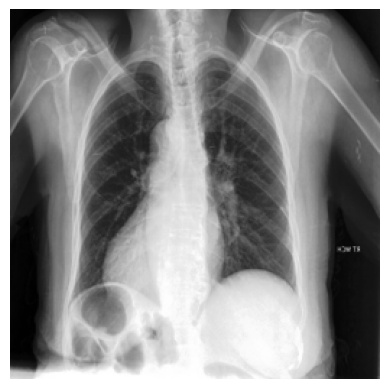

In [3]:
from sklearn.preprocessing import MinMaxScaler
import cv2
import numpy as np


image_directory = "images/images_normalized/"

def process_images(image_dir):
    processed_images = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            # Resize the image (e.g., to 256x256)
            img = img.resize((256, 256))

            # Convert to grayscale
            img = img.convert("L")

            # Convert to numpy array
            img_array = np.array(img)

            # Clip pixel values (remove extremes)
            img_array = np.clip(img_array, 0, 255)

            # Normalize pixel values to range [0, 1]
            img_array = img_array / 255.0

            # Histogram equalization for contrast enhancement
            img_array = cv2.equalizeHist((img_array * 255).astype(np.uint8))

            # Convert back to float32
            img_array = img_array.astype(np.float32) / 255.0

            # Optionally, apply data augmentation (random rotation, flipping)
            if np.random.rand() > 0.5:
                img_array = cv2.rotate(img_array, cv2.ROTATE_90_CLOCKWISE)  # Rotate
            if np.random.rand() > 0.5:
                img_array = np.fliplr(img_array)  # Flip horizontally

            processed_images.append(img_array)

    return processed_images

# Process images
normalized_images = process_images(image_directory)

# Example of displaying a processed image
import matplotlib.pyplot as plt

plt.imshow(normalized_images[0], cmap='gray')
plt.axis('off')
plt.show()

# **Mapreduce with csv files**

Top MeSH-Indication combinations based on weighted score:
+------+--------------------+------------------+------------+--------------+
|  MeSH|          indication| avgFindingsLength|totalReports|weighted_score|
+------+--------------------+------------------+------------+--------------+
|normal|          chest pain|148.55555555555554|         117|       17381.0|
|normal|                xxxx| 144.8695652173913|          69|        9996.0|
|normal|             dyspnea|147.75862068965517|          29|        4285.0|
|normal|xxxxyearold femal...|177.79166666666666|          24|        4267.0|
|normal|xxxxyearold male ...| 183.6086956521739|          23|        4223.0|
|normal|xxxxyearold woman...|210.41666666666666|          12|        2525.0|
|normal|xxxxyearold xxxx ...|201.16666666666666|          12|        2414.0|
|normal|       Not Specified|110.52380952380952|          21|        2321.0|
|normal|xxxxyearold femal...| 150.3846153846154|          13|        1955.0|
|normal| shortness

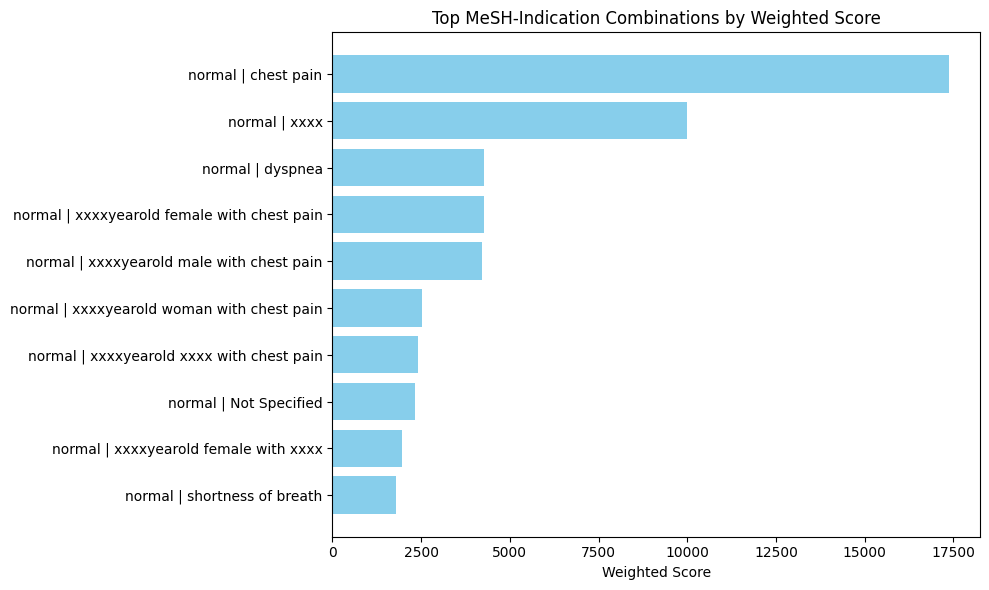

In [4]:
# MapReduce Algorithm - Extracting and Summarizing Data
# Step 1: Map each row into a key-value pair (MeSH + indication, (findingsLength, 1))
map_rdd = reports_df.rdd.map(lambda row: ((row['MeSH'], row['indication']), (row['findingsLength'], 1)))

# Step 2: Reduce by key to calculate the total findings length and count of reports for each MeSH-indication pair
reduce_rdd = map_rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Step 3: Calculate average findings length and create a weighted score
# Weighted score = avgFindingsLength * totalReports
result_rdd = reduce_rdd.map(lambda x: (x[0][0], x[0][1], x[1][0] / x[1][1], x[1][1], (x[1][0] / x[1][1]) * x[1][1]))

# Convert the RDD back to a DataFrame for easier handling
result_df = result_rdd.toDF(["MeSH", "indication", "avgFindingsLength", "totalReports", "weighted_score"])

# Filter for significant entries with more than 10 reports
significant_data = result_df.filter(col("totalReports") > 10)

# Sort by weighted_score to find the most critical 'MeSH' - 'indication' combinations
sorted_data = significant_data.orderBy(col("weighted_score").desc())

# Show the top results
print("Top MeSH-Indication combinations based on weighted score:")
sorted_data.show(10)

# Save the output for further analysis
output_path = "complex_mesh_indication_analysis.csv"
sorted_data.write.csv(output_path, header=True)

# Optional: Visualization Example (Using Matplotlib)
import pandas as pd

# Convert the top combinations to a Pandas DataFrame for visualization
top_combinations_pd = sorted_data.limit(10).toPandas()

# Plotting the top combinations
plt.figure(figsize=(10, 6))
plt.barh(top_combinations_pd['MeSH'] + " | " + top_combinations_pd['indication'], top_combinations_pd['weighted_score'], color='skyblue')
plt.xlabel('Weighted Score')
plt.title('Top MeSH-Indication Combinations by Weighted Score')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

# **Mapreduce combining images and csv file data**

In [6]:
import re
from pyspark.sql.types import FloatType

def extract_image_features(image_dir, view_type_df, max_images=100):
    """
    Extracts image features like average intensity and contrast for a limited number of images.
    Args:
    - image_dir (str): Directory containing the images.
    - view_type_df (DataFrame): DataFrame with image view types (lateral, frontal).
    - max_images (int): Maximum number of images to process.
    Returns:
    - DataFrame with image features.
    """
    image_features = []
    images = os.listdir(image_dir)[:max_images]  # Limit the number of images processed

    for img_name in images:
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            img = img.resize((256, 256))  # Resize for uniformity
            img_array = np.array(img.convert("L"))  # Convert to grayscale

            # Calculate features
            avg_intensity = float(img_array.mean())  # Average pixel intensity
            contrast = float(img_array.std())  # Contrast level

            # Extract UID from the image name using regex to match the first set of digits
            uid_match = re.match(r"(\d+)", img_name)
            if uid_match:
                numeric_uid = int(uid_match.group(1))  # Extract the first matched group as an integer
            else:
                continue  # Skip this image if no valid UID is found

            # Get view type from projections DataFrame
            view_type_row = view_type_df.filter(col("uid") == numeric_uid).select("projection").first()
            view_type = view_type_row[0] if view_type_row else "Unknown"

            image_features.append((numeric_uid, avg_intensity, contrast, view_type))

    # Convert to DataFrame
    columns = ["uid", "avg_intensity", "contrast", "view_type"]
    image_features_rdd = spark.sparkContext.parallelize(image_features)
    image_features_df = image_features_rdd.toDF(columns)
    image_features_df = image_features_df.withColumn("avg_intensity", col("avg_intensity").cast(FloatType())) \
                                         .withColumn("contrast", col("contrast").cast(FloatType()))

    return image_features_df
    # Step 2: Extract image features with adjusted UIDs
image_directory = "images/images_normalized/"
image_features_df = extract_image_features(image_directory, projections_df, max_images=100)

# Step 3: Join image features with reports data using 'uid'
combined_df = reports_df.join(image_features_df, on="uid", how="inner")

# Debug: Check if combined_df is empty
print("Combined DataFrame Count:", combined_df.count())
combined_df.show(5)  # Display the first 5 rows for verification

# Step 4: MapReduce Analysis
# Map each row into a key-value pair (MeSH + indication + view_type, (findingsLength, avg_intensity, 1))
map_rdd = combined_df.rdd.map(
    lambda row: (
        (row['MeSH'], row['indication'], row['view_type']),
        (row['findingsLength'], row['avg_intensity'], 1)
    )
)

# Step 5: Reduce by key to calculate totals
# Summing findings lengths, intensities, and counts for each (MeSH, indication, view_type)
reduce_rdd = map_rdd.reduceByKey(
    lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2])
)

# Step 6: Calculate averages and create a result RDD
result_rdd = reduce_rdd.map(
    lambda x: (
        x[0][0],  # MeSH
        x[0][1],  # indication
        x[0][2],  # view_type
        x[1][0] / x[1][2] if x[1][2] > 0 else 0,  # avgFindingsLength
        x[1][1] / x[1][2] if x[1][2] > 0 else 0,  # avgIntensity
        x[1][2]  # totalReports
    )
)

# Convert the RDD back to a DataFrame
result_df = result_rdd.toDF(["MeSH", "indication", "view_type", "avgFindingsLength", "avgIntensity", "totalReports"])

# Step 8: Relax filter for significant entries with at least 1 report
significant_data = result_df.filter(col("totalReports") > 0)

# Step 9: Sort by avgFindingsLength or avgIntensity to find key insights
sorted_data = significant_data.orderBy(col("avgFindingsLength").desc())

# Show the top results after relaxing the criteria
print("Top MeSH-Indication-View Type combinations based on average findings length (at least 1 report):")
sorted_data.show(10)



Combined DataFrame Count: 84
+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------------+---------+---------+
| uid|                MeSH|            Problems|               image|          indication|          comparison|            findings|          impression|findingsLength|       combined_info|avg_intensity| contrast|view_type|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------------+---------+---------+
|1204|cardiomegalymilda...|cardiomegalyaorta...|2 views chest PA ...|          chest pain|                xxxx|pa and lateral vi...|no acute cardiopu...|           241|chest pain pa and...|    158.60728|52.748325|  Frontal|
|1179|opacitycicatrixmi...|opacitycicatrixsu...|PA and Lateral Ch...|     b

# **Aggregation by broader categories of MeSH terms and indications**

In [7]:
import os
import re
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, StructType, StructField, FloatType
from pyspark.sql import DataFrame
from pyspark.sql.functions import udf
from PIL import Image

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Chest X-rays Analysis") \
    .getOrCreate()

# Step 1: Define the mapping for broader categories
mesh_mapping = {
    'cardiomegaly': 'Cardiovascular Issues',
    'opacity': 'Lung Conditions',
    'scoliosis': 'Spinal Conditions',
    'normal': 'Normal Findings',
    'thoracic vertebrae': 'Spinal Conditions',
    'catheters indwelling': 'Cardiovascular Issues',
    'granulomatous disease': 'Lung Conditions',
    'atherosclerosis': 'Cardiovascular Issues',
    # Add more mappings as necessary
}

indication_mapping = {
    'chest pain': 'Chest Symptoms',
    'backache': 'Back Symptoms',
    'dyspnea': 'Breathing Symptoms',
    'xxxxyearold female': 'General Cases',
    'mvc leukocytosis': 'Trauma Cases',
    # Add more mappings as necessary
}

# Step 2: Broadcast the mapping dictionaries for performance
mesh_mapping_bc = spark.sparkContext.broadcast(mesh_mapping)
indication_mapping_bc = spark.sparkContext.broadcast(indication_mapping)

# Step 3: Replace specific terms with broader categories
def map_mesh_and_indication(mesh, indication):
    broad_mesh = mesh_mapping_bc.value.get(mesh, mesh)  # Use original if not found
    broad_indication = indication_mapping_bc.value.get(indication, indication)
    return broad_mesh, broad_indication

# Create a UDF for mapping
map_udf = udf(map_mesh_and_indication, StructType([
    StructField("broad_mesh", StringType(), True),
    StructField("broad_indication", StringType(), True),
]))

# Step 4: Function to extract image features
def extract_image_features(image_dir, view_type_df, max_images=100):
    """
    Extracts image features like average intensity and contrast for a limited number of images.
    Args:
    - image_dir (str): Directory containing the images.
    - view_type_df (DataFrame): DataFrame with image view types (lateral, frontal).
    - max_images (int): Maximum number of images to process.
    Returns:
    - DataFrame with image features.
    """
    image_features = []
    images = os.listdir(image_dir)[:max_images]  # Limit the number of images processed

    for img_name in images:
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            img = img.resize((256, 256))  # Resize for uniformity
            img_array = np.array(img.convert("L"))  # Convert to grayscale

            # Calculate features
            avg_intensity = float(img_array.mean())  # Average pixel intensity
            contrast = float(img_array.std())  # Contrast level

            # Extract UID from the image name using regex to match the first set of digits
            uid_match = re.match(r"(\d+)", img_name)
            if uid_match:
                numeric_uid = int(uid_match.group(1))  # Extract the first matched group as an integer
            else:
                continue  # Skip this image if no valid UID is found

            # Get view type from projections DataFrame
            view_type_row = view_type_df.filter(F.col("uid") == numeric_uid).select("projection").first()
            view_type = view_type_row[0] if view_type_row else "Unknown"

            image_features.append((numeric_uid, avg_intensity, contrast, view_type))

    # Convert to DataFrame
    columns = ["uid", "avg_intensity", "contrast", "view_type"]
    image_features_rdd = spark.sparkContext.parallelize(image_features)
    image_features_df = image_features_rdd.toDF(columns)
    image_features_df = image_features_df.withColumn("avg_intensity", F.col("avg_intensity").cast(FloatType())) \
                                         .withColumn("contrast", F.col("contrast").cast(FloatType()))

    return image_features_df

# Step 5: Extract image features
image_directory = "images/images_normalized/"
image_features_df = extract_image_features(image_directory, projections_df, max_images=100)

# Step 6: Join image features with reports data using 'uid'
combined_df = reports_df.join(image_features_df, on="uid", how="inner")

# Step 7: Apply the UDF to create new columns for broader categories
combined_df_with_broad = combined_df.withColumn("mapped", map_udf("MeSH", "indication")) \
    .withColumn("broad_mesh", F.col("mapped.broad_mesh")) \
    .withColumn("broad_indication", F.col("mapped.broad_indication")) \
    .drop("mapped")  # Drop the intermediate column

# Step 8: Aggregate the data by broader categories including image features
aggregated_data = combined_df_with_broad.groupBy("broad_mesh", "broad_indication", "view_type").agg(
    F.avg("findingsLength").alias("avgFindingsLength"),
    F.avg("avg_intensity").alias("avgIntensity"),
    F.count("uid").alias("totalReports"),
    F.avg("contrast").alias("avgContrast")  # Include average contrast in aggregation
)

# Step 9: Show the aggregated data
print("Aggregated Data by Broader Categories:")
aggregated_data.show(truncate=False)


Aggregated Data by Broader Categories:
+-----------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------+---------+------------------+------------------+------------+------------------+
|broad_mesh                                                                                                       |broad_indication                                                                |view_type|avgFindingsLength |avgIntensity      |totalReports|avgContrast       |
+-----------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------+---------+------------------+------------------+------------+------------------+
|cardiomegalymildaorta thoracictortuousmild                                                                       |Chest Symptoms 

# **Visualizations**

<ipython-input-8-c4b9d97b0e39>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='avgIntensity', y='broad_mesh', data=aggregated_pd[aggregated_pd['broad_mesh'].isin(top_mesh_conditions)], ci=None)


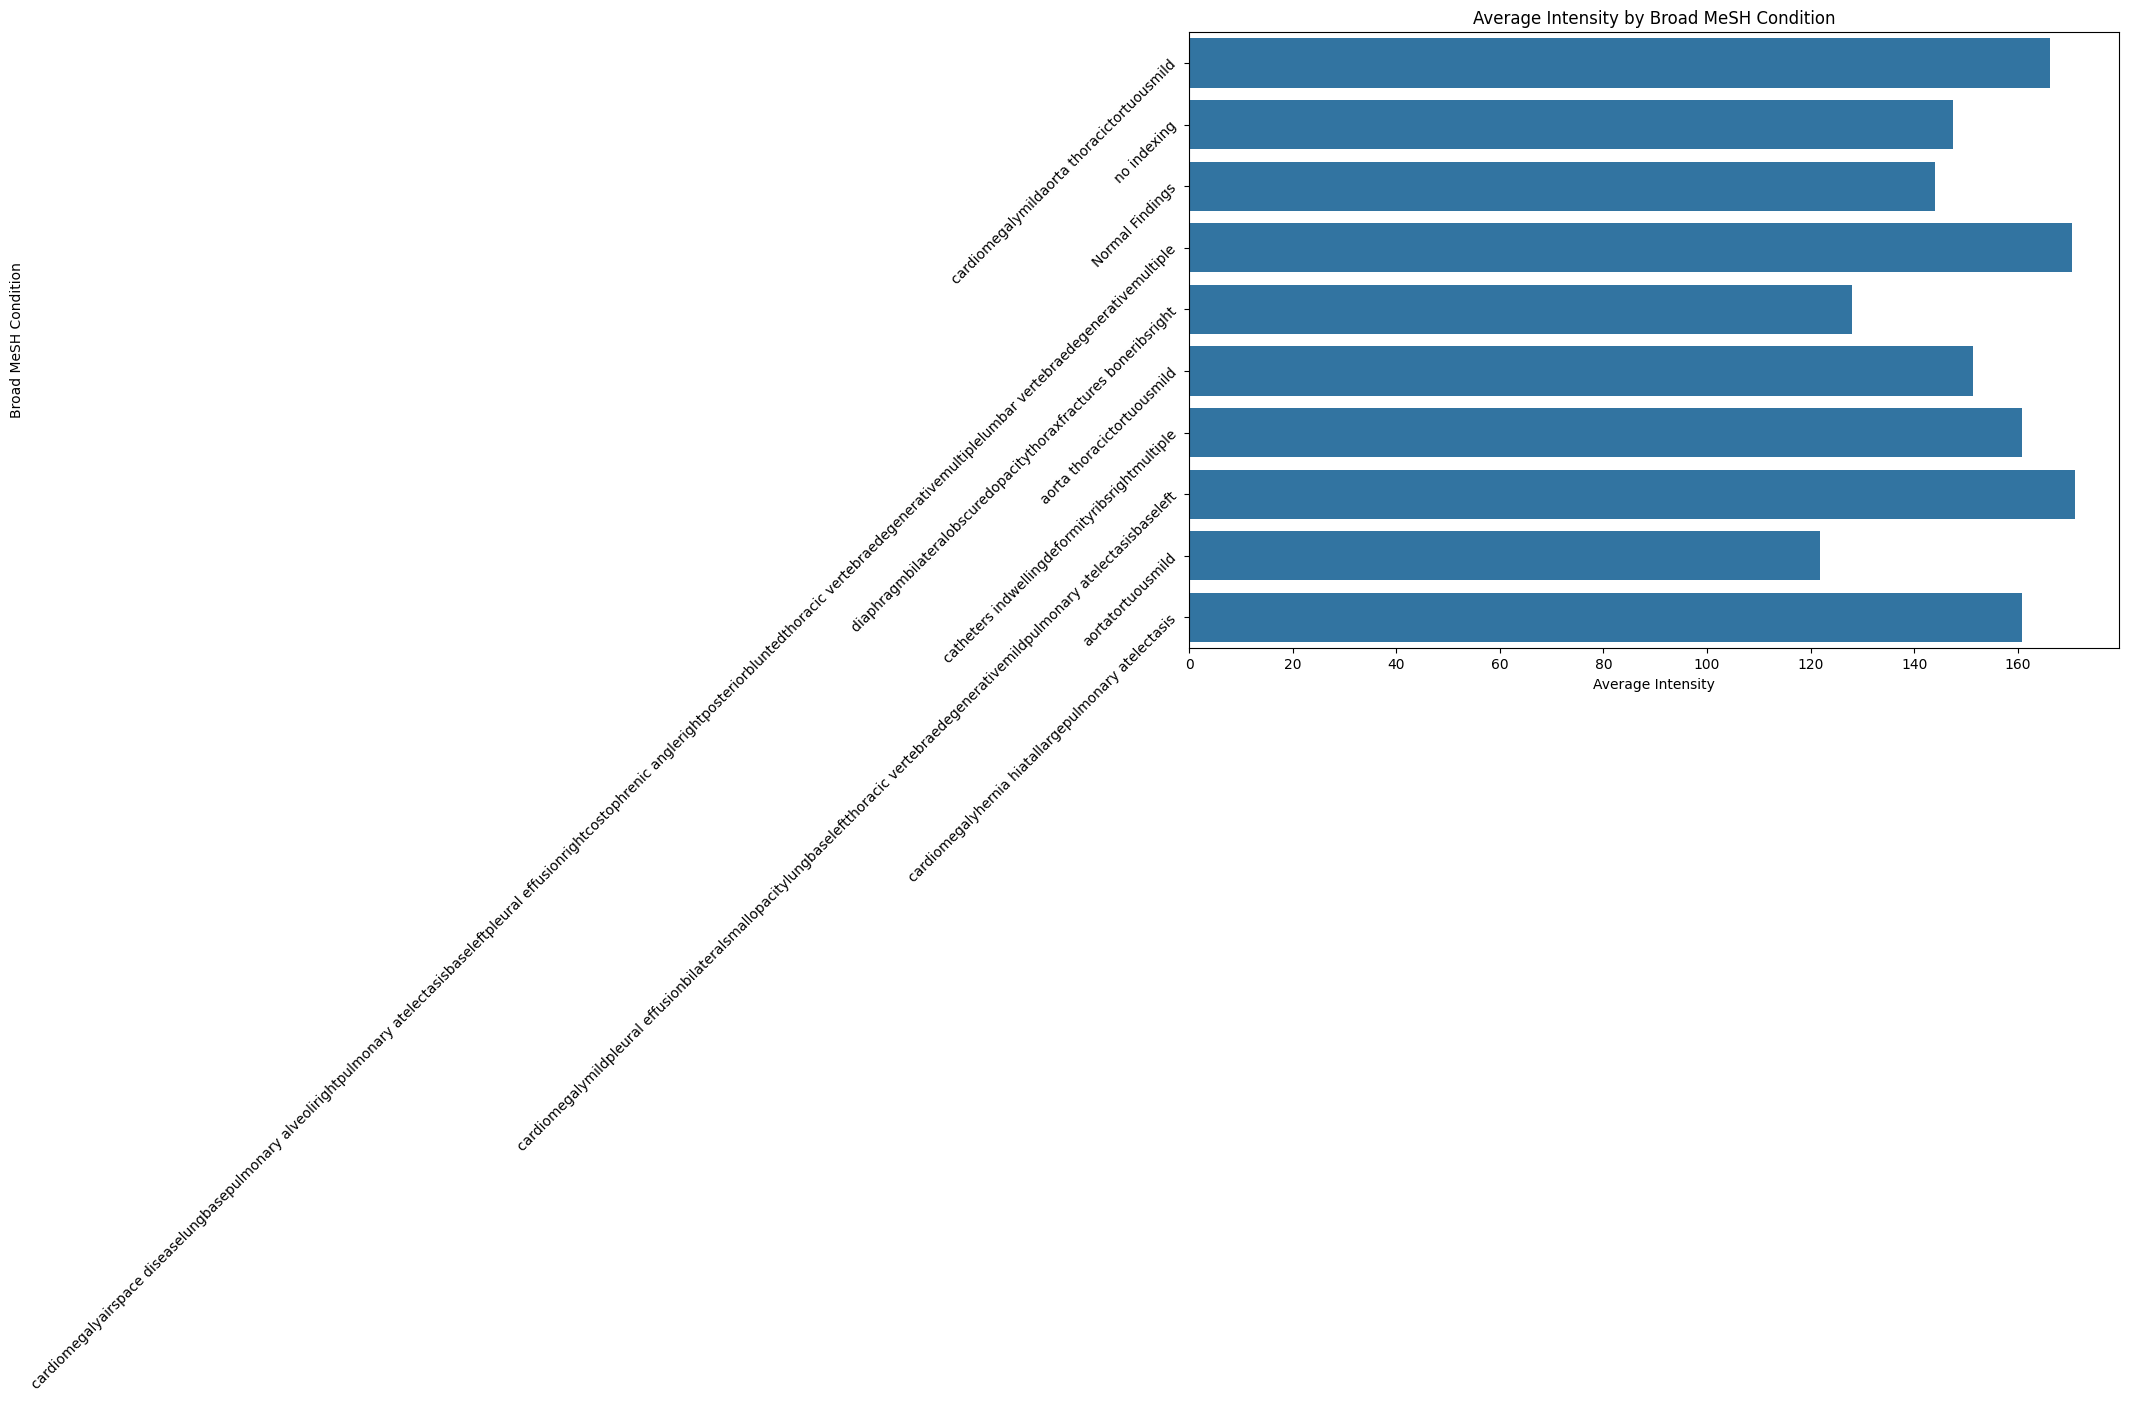

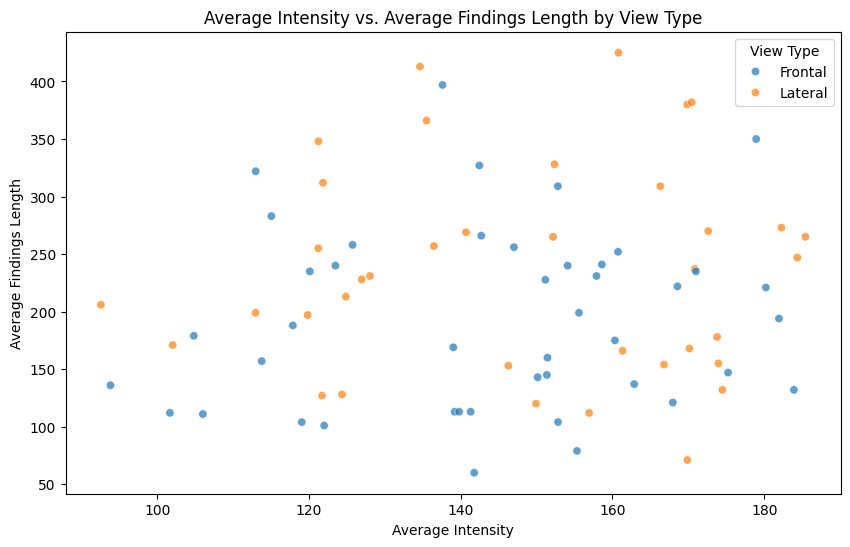

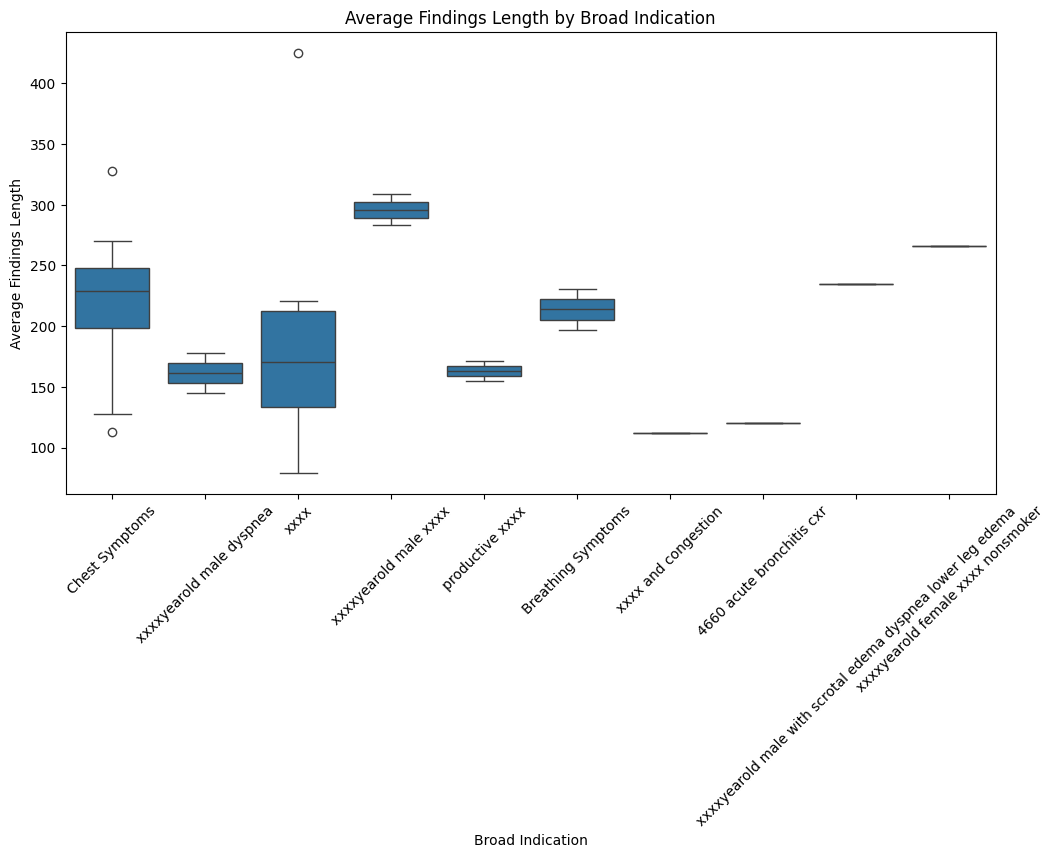

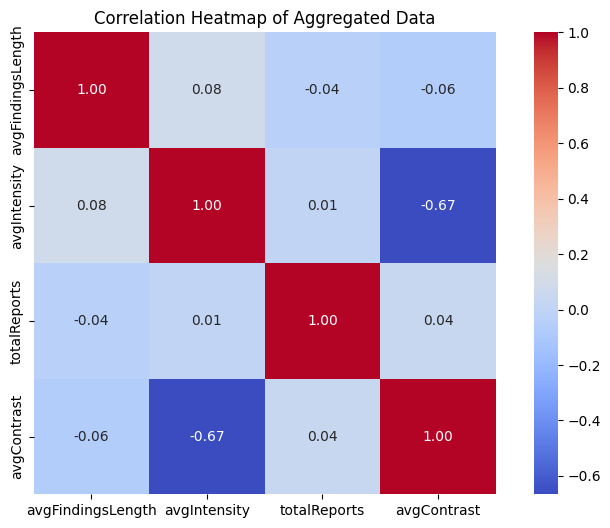

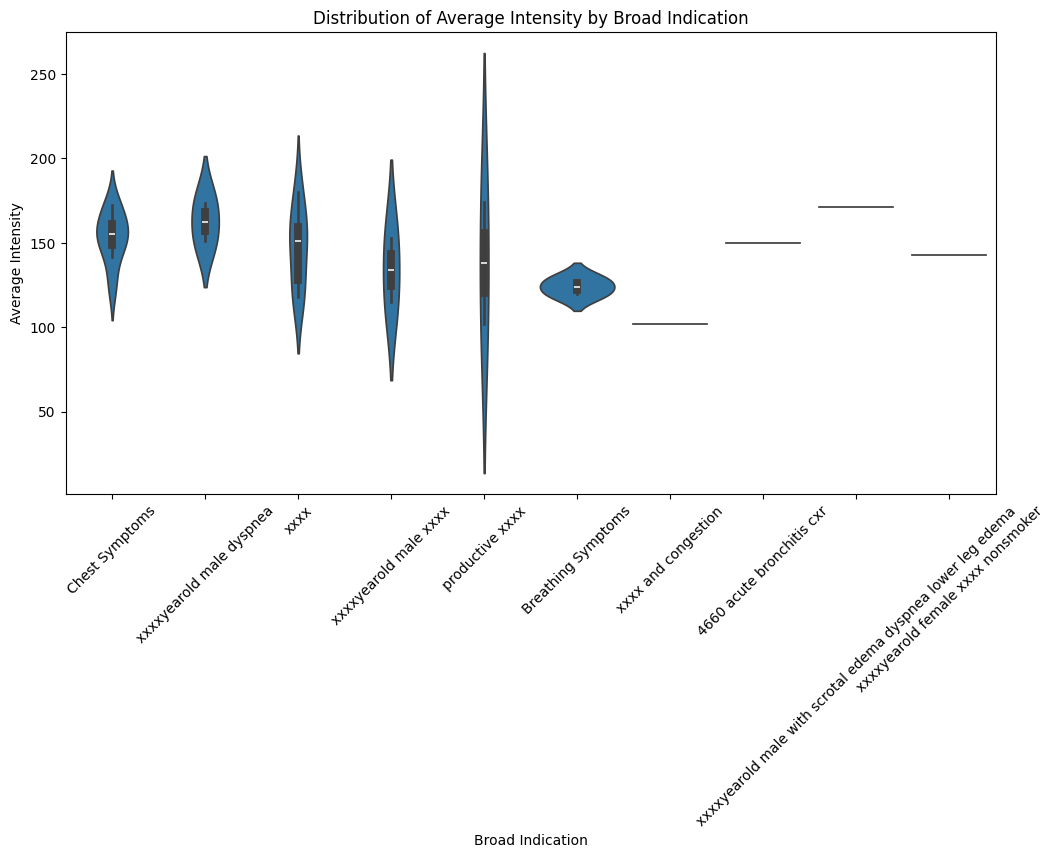

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'aggregated_data' is already available from previous steps
# Convert to Pandas DataFrame for visualization
aggregated_pd = aggregated_data.toPandas()

# 1. Horizontal Bar Plot of Average Intensity by Broad MeSH Condition
top_mesh_conditions = aggregated_pd['broad_mesh'].value_counts().nlargest(10).index.tolist()
plt.figure(figsize=(12, 8))
sns.barplot(x='avgIntensity', y='broad_mesh', data=aggregated_pd[aggregated_pd['broad_mesh'].isin(top_mesh_conditions)], ci=None)

plt.title('Average Intensity by Broad MeSH Condition')
plt.xlabel('Average Intensity')
plt.ylabel('Broad MeSH Condition')
plt.yticks(rotation=45)  # Rotate y-axis labels for better visibility
plt.show()

# 2. Scatter Plot of Average Intensity vs. Findings Length
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avgIntensity', y='avgFindingsLength', hue='view_type', data=aggregated_pd, alpha=0.7)
plt.title('Average Intensity vs. Average Findings Length by View Type')
plt.xlabel('Average Intensity')
plt.ylabel('Average Findings Length')
plt.legend(title='View Type')
plt.show()

# 3. Box Plot of Average Findings Length by Broad Indication
top_indications = aggregated_pd['broad_indication'].value_counts().nlargest(10).index.tolist()
plt.figure(figsize=(12, 6))
sns.boxplot(x='broad_indication', y='avgFindingsLength', data=aggregated_pd[aggregated_pd['broad_indication'].isin(top_indications)])

plt.title('Average Findings Length by Broad Indication')
plt.xlabel('Broad Indication')
plt.ylabel('Average Findings Length')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

# 4. Heatmap of Correlations
plt.figure(figsize=(10, 6))
correlation_matrix = aggregated_pd[['avgFindingsLength', 'avgIntensity', 'totalReports', 'avgContrast']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Aggregated Data')
plt.show()

# 5. Violin Plot of Average Intensity by Broad Indication
plt.figure(figsize=(12, 6))
sns.violinplot(x='broad_indication', y='avgIntensity', data=aggregated_pd[aggregated_pd['broad_indication'].isin(top_indications)])

plt.title('Distribution of Average Intensity by Broad Indication')
plt.xlabel('Broad Indication')
plt.ylabel('Average Intensity')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()